# Importing important modules and loading Dataset

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import datetime
from datetime import date, datetime

In [2]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import confusion_matrix, classification_report # classification metrics
from imblearn.over_sampling import SMOTE # SMOTE

In [3]:
train = pd.read_csv('../datasets/fraudTrain.csv')
test = pd.read_csv('../datasets/fraudTest.csv')

dataset = pd.concat([train, test], ignore_index = True)
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


# Preprocessing datasets

In [5]:
class PreprocessorML():
    def __init__(self, normalization=False):
        self.norm = normalization
    

    def one_hot_category(self, dataset):
        hot = ['gas_transport', 'grocery_pos', 'home', 'shopping_pos', 'kids_pets', 'shopping_net', 'entertainment',
               'food_dining', 'personal_care', 'health_fitness', 'misc_pos', 'misc_net', 'grocery_net', 'travel']
        
        for category in hot:
            dataset[category] = pd.Series([1 if x.category == category else 0 for x in dataset.itertuples()],
                                          index=dataset.index)
        
        return dataset


    def add_time(self, dataset):
        dataframe = dataset.sort_values(by=['cc_num', 'unix_time'])

        delta_time = []

        previous_row = dataframe.iloc[0]

        delta_time.append(0)

        for row in dataframe[1:].itertuples():

            if row.cc_num == previous_row.cc_num:
                delta_time.append(row.unix_time - previous_row.unix_time)
            else:
                delta_time.append(0)

            previous_row = row

        dataframe['delta_time'] = pd.Series(delta_time, index=dataframe.index)

        return dataframe


    def parse_time(self, string):
        return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


    def add_workhour_category(self, dataset):
        dataset['work_hours'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).hour >= 6 and self.parse_time(x).hour <= 18))
        return dataset


    def add_weekend_category(self, dataset):
        dataset['weekend'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).weekday() >= 5 and self.parse_time(x).weekday() <= 6))
        return dataset

    
    def add_age(self, dataset):
        dataset['age'] = dataset['dob'].apply(lambda x: (date.today() - date.fromisoformat(x)).days // 365)
        return dataset


    def add_distance(self, dataset):
        lat1 = dataset['lat']
        lon1 = dataset['long']
        lat2 = dataset['merch_lat']
        lon2 = dataset['merch_long']
        dataset['distance'] = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)) * 6371
        return dataset

    
    def add_gender(self, dataset):
        dataset['gender'] = pd.Categorical(dataset['gender'], categories=['F', 'M'])
        hot = pd.get_dummies(dataset['gender'], columns = ['F', 'M'])
        
        return dataset.join(hot)


    def add_weekday(self, dataset):
        dataset['weekday'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).weekday()))
        
        return dataset
    
    def add_hour(self, dataset):
        dataset['hour'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).hour))
        
        return dataset


    def preprocess(self, dataset):
        dataset = self.add_age(dataset)
        dataset = self.add_time(dataset)
        dataset = self.add_distance(dataset)
        dataset = self.one_hot_category(dataset)
        dataset = self.add_workhour_category(dataset)
        dataset = self.add_weekend_category(dataset)
        dataset = self.add_gender(dataset)
        print(type(dataset))
        dataset = self.add_hour(dataset)
        print(type(dataset))
        dataset = self.add_weekday(dataset)
        print(type(dataset))

        dataset = dataset.drop(['cc_num', 
                      'city', 
                      'dob', 
                      'job', 
                      'first', 
                      'last',
                      'trans_date_trans_time',
                      'category',
                      'trans_num',
                      'lat',
                      'long',
                      'merch_lat',
                      'merch_long',
                      'unix_time',
                      'street',
                      'merchant',
                      'state',
                      'gender'], axis = 1)

        return dataset

In [6]:
preprocessor = PreprocessorML()
dataset = preprocessor.preprocess(dataset)
dataset

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,amt,zip,city_pop,is_fraud,age,delta_time,distance,gas_transport,grocery_pos,home,...,misc_pos,misc_net,grocery_net,travel,work_hours,weekend,F,M,hour,weekday
1017,7.27,82514,1645,0,37,0,7543.700547,0,0,0,...,0,1,0,0,1,0,True,False,12,1
2724,52.94,82514,1645,0,37,71862,6264.188302,1,0,0,...,0,0,0,0,1,0,True,False,8,2
2726,82.08,82514,1645,0,37,159,939.418661,1,0,0,...,0,0,0,0,1,0,True,False,8,2
2882,34.79,82514,1645,0,37,13838,4937.313870,0,0,0,...,0,0,0,0,1,0,True,False,12,2
2907,27.18,82514,1645,0,37,1952,3941.877584,0,0,1,...,0,0,0,0,1,0,True,False,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,66.11,61335,532,0,67,8077,3043.216367,1,0,0,...,0,0,0,0,0,0,False,True,2,3
1849567,4.58,61335,532,0,67,11005,5377.002667,0,0,0,...,0,1,0,0,0,0,False,True,5,3
1850234,95.96,61335,532,0,67,21729,2151.742759,1,0,0,...,0,0,0,0,1,0,False,True,11,3
1850235,149.48,61335,532,0,67,101,5406.444488,0,1,0,...,0,0,0,0,1,0,False,True,11,3


# Fitting  Random Forest Tree

In [7]:
dataset = pd.read_csv('../../models/dataset_ml_v2.csv')

In [8]:
y = dataset['is_fraud']
X = dataset.drop(['is_fraud'], axis=1)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import xgboost as xgb

xgb.set_config(verbosity=2)

In [10]:
X_test

,amt,zip,city_pop,age,delta_time,distance,gas_transport,grocery_pos,home,shopping_pos,...,misc_pos,misc_net,grocery_net,travel,work_hours,weekend,F,M,hour,weekday
19185,49.81,65680,1201,43,7697,3251.444253,0,0,0,0,...,0,0,1,0,1,0,False,True,9,3
2207,31.91,29860,46944,81,24454,4235.678873,0,0,0,0,...,0,0,0,0,1,1,False,True,16,5
18597,48.07,13342,165,78,4201,886.649176,0,0,0,0,...,0,0,0,0,1,0,True,False,12,0
1640,43.43,82514,1645,37,22397,4143.308133,1,0,0,0,...,0,0,0,0,0,0,True,False,2,0
17989,2.55,13342,165,78,21743,672.586921,0,0,0,0,...,0,0,0,0,0,0,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18684,76.75,13342,165,78,33558,2718.859004,1,0,0,0,...,0,0,0,0,1,0,True,False,11,2
6521,14.35,39211,233060,51,123831,4943.091626,0,0,0,0,...,0,0,0,0,1,0,False,True,16,4
13267,24.68,39653,2799,62,100001,5864.819482,0,0,0,0,...,1,0,0,0,1,0,True,False,10,0
17998,46.75,13342,165,78,77958,4934.606060,0,0,0,0,...,0,0,1,0,1,0,True,False,8,4


In [11]:
xgb_cl = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='auc', n_jobs=-1, tree_method='gpu_hist', grow_policy='lossguide',)

In [12]:
xgb_cl.fit(X_train, y_train)

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
xgb_pred = xgb_cl.predict(X_test)

print(confusion_matrix(y_test,xgb_pred))
print('\n')
print(classification_report(y_test,xgb_pred))

[[7212    0]
 [  16   36]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7212
           1       1.00      0.69      0.82        52

    accuracy                           1.00      7264
   macro avg       1.00      0.85      0.91      7264
weighted avg       1.00      1.00      1.00      7264



c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

In [14]:
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [15]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb

#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

In [16]:
default_params = {}
gparams = xgb_cl.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]
params = deepcopy(default_params)

In [17]:
results_dict = {}

In [18]:
clf0 = GridSearchCV(estimator=xgb_cl, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3, n_jobs=-1)
clf0.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy='lossguide',
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learnin...
                         'max_cat_threshold': [None],
                         'max_cat_to_onehot': [None], 'max_delta_step': [None],
                         'max_depth': [None], 'max_leaves': [None],
                         'min_child_weight': [None], 'missing': [nan],
                         'monotone_constraints': [None],
                         'multi_strategy': [None], 'n_estimators': [None],
                         'n_jobs': [-1], 'num_parallel_tree': [None],
                         'objective': ['binary:logistic'], ...},
             return_train_score=True, scoring='accuracy', verbose=1)

In [19]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train.values.ravel())
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'test roc auc score': test_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 3 folds for each of 13 candidates, totalling 39 fits


c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

iteration #1 finished in: 56.358039140701294 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

iteration #2 finished in: 138.2717261314392 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

In [ ]:
list(results_dict)

['xgbc1', 'xgbc2', 'xgbc3', 'xgbc4', 'xgbc5', 'xgbc6']

In [ ]:
for lb in results_dict:
    print(lb, results_dict[lb]['test F1-score label 1'])

xgbc1 0.8798394034987096
xgbc2 0.8798394034987096
xgbc3 0.8798394034987096
xgbc4 0.8798394034987096
xgbc5 0.8798394034987096
xgbc6 0.8837606837606838


In [ ]:
results_dict['xgbc4']

{'iterable_parameter': 'n_estimators',
 'classifier': GridSearchCV(cv=3,
              estimator=XGBClassifier(base_score=[None], booster=['gbtree'],
                                      callbacks=[None], colsample_bylevel=[None],
                                      colsample_bynode=[None],
                                      colsample_bytree=[None], device=[None],
                                      early_stopping_rounds=[None],
                                      enable_categorical=[False],
                                      eval_metric=['auc'], feature_types=[None],
                                      gamma=[None], grow_policy=['lossguide'],
                                      importance_type=[None],
                                      interact...
                          'max_cat_to_onehot': [None], 'max_delta_step': [None],
                          'max_depth': [6], 'max_leaves': [None],
                          'min_child_weight': [None], 'missing': [nan],
  

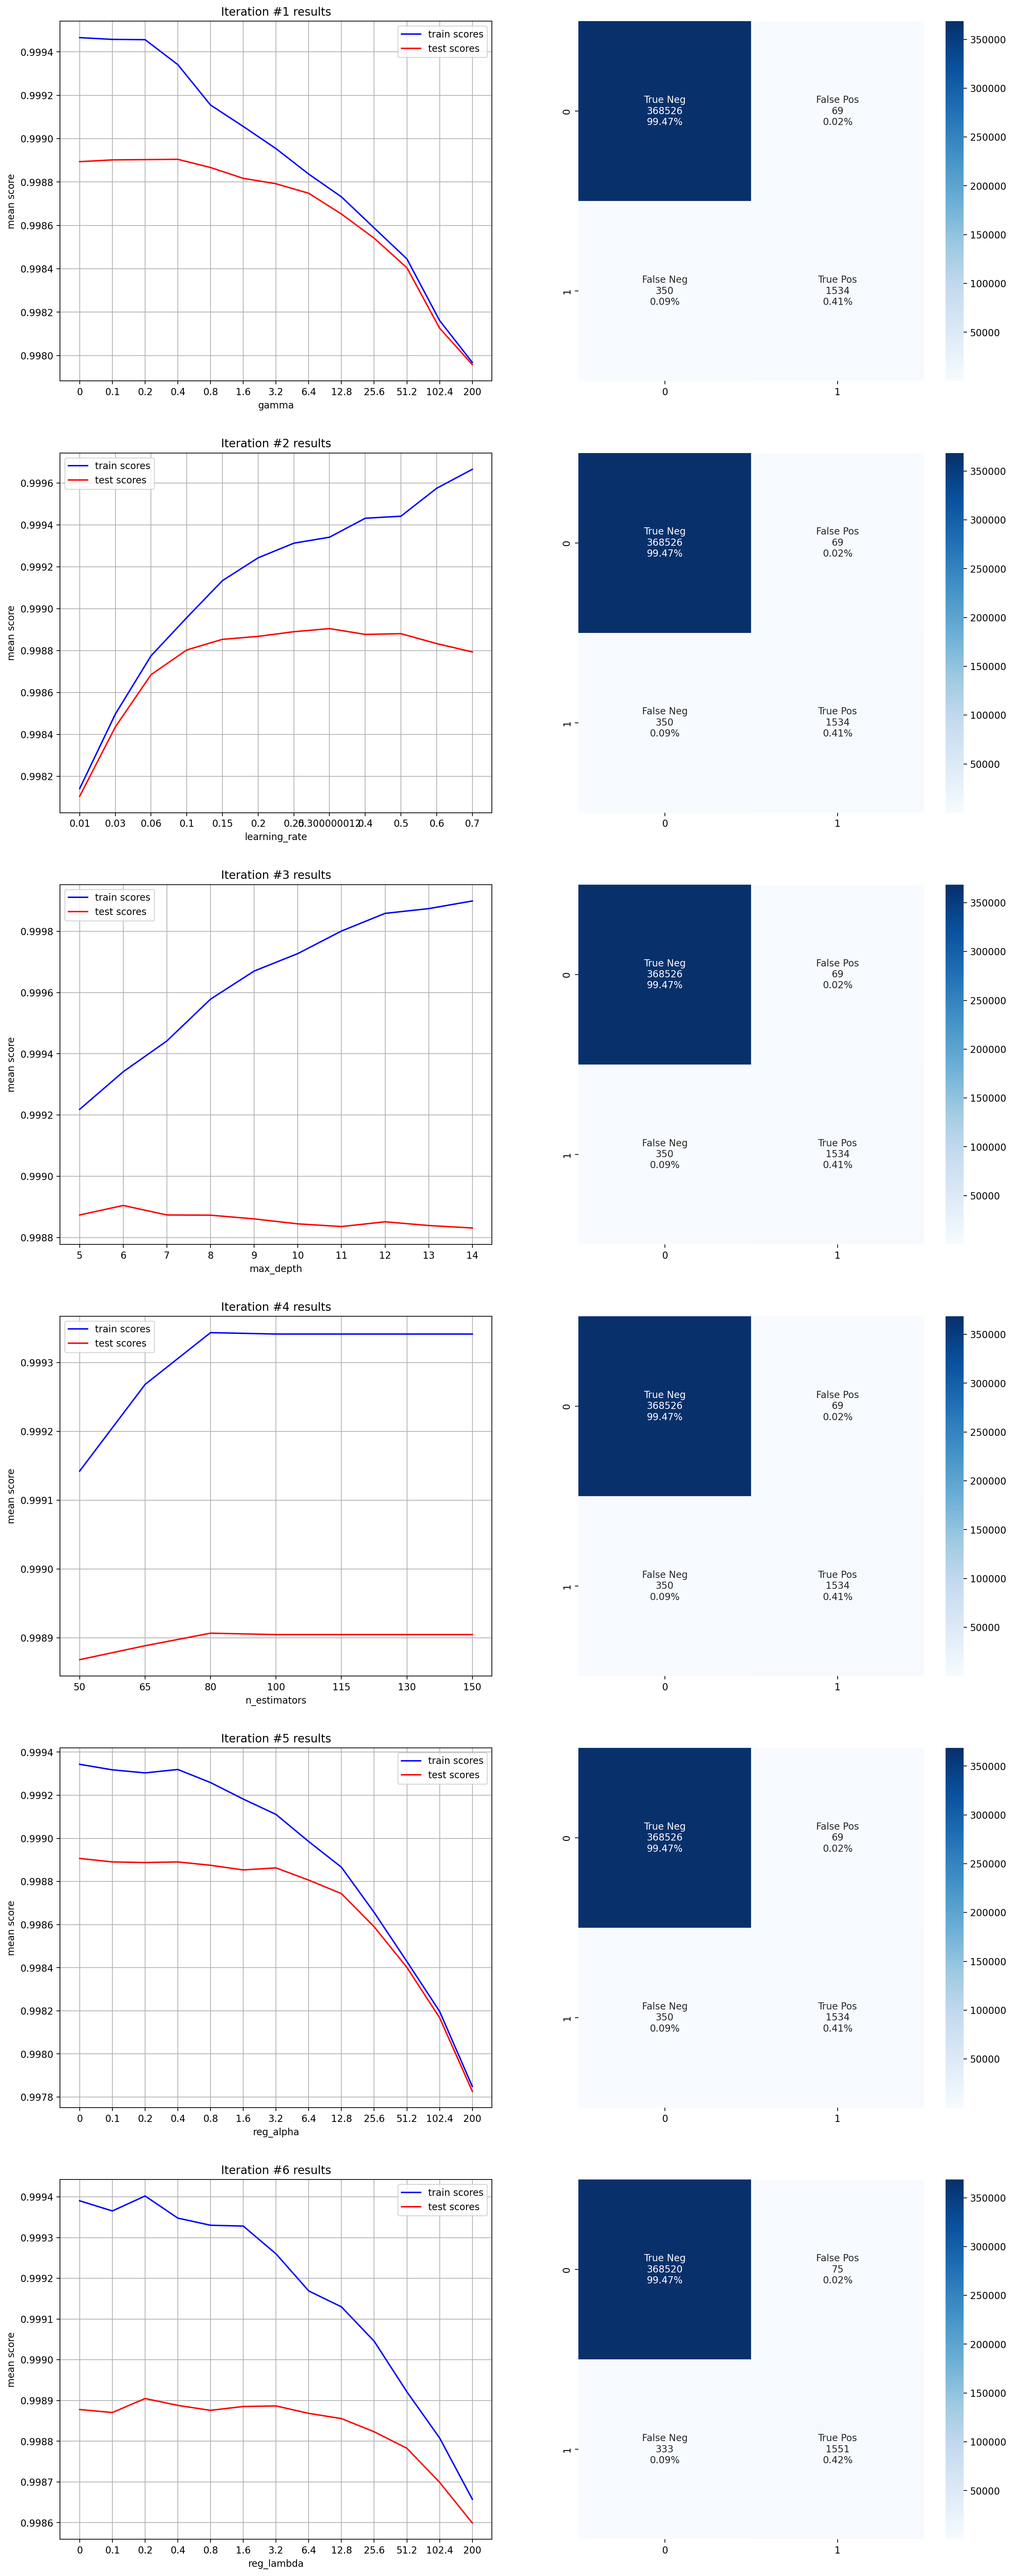

In [ ]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show()

In [ ]:
xgb_cl.save_model('model_xgb_cl_v_1.json')

In [ ]:
xgb_reg = xgb.XGBRegressor(n_jobs=-1, tree_method='gpu_hist')

In [ ]:
xgb_reg.load_model('../../models/model_xgb_reg_v_1.json')

In [ ]:
import joblib

In [ ]:
md = joblib.load('random_forest_regressor.ml')

In [ ]:
len(X)

1852394

In [ ]:
import time
start = time.time()
_ = md.predict(X)
end = time.time()
print(end - start)

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


3.6738569736480713


In [ ]:
15.672512531280518/1852394

8.460679818267884e-06

In [ ]:
xgb_reg.fit(X_train, y_train)

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'int', 'int', 'int', 'int', 'float', 'int',
                            'int', 'int', 'int', 'int', 'int', 'int', 'int',
                            'int', 'int', 'int', 'int', 'int', 'int', 'int',...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_reg.load_model("../../models/model_xgb_reg_v_1.json")

In [ ]:
xgb_preds = xgb_reg.predict(X_test)

for j in np.arange(0.1, 1, 0.1):
    xgb_pred = xgb_preds >= j
    print(j)
    print(confusion_matrix(y_test,xgb_pred))
    print('\n')
    print(classification_report(y_test,xgb_pred))

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages

0.1
[[367786    809]
 [   172   1712]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.68      0.91      0.78      1884

    accuracy                           1.00    370479
   macro avg       0.84      0.95      0.89    370479
weighted avg       1.00      1.00      1.00    370479

0.2
[[368285    310]
 [   238   1646]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.84      0.87      0.86      1884

    accuracy                           1.00    370479
   macro avg       0.92      0.94      0.93    370479
weighted avg       1.00      1.00      1.00    370479

0.30000000000000004
[[368433    162]
 [   297   1587]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.91      0.84      0.87      1884

    accuracy                           1.00    370479
   macro avg       0.95      0.92      0.94    370479
weighted avg       1.00      1.00      1.00    370479

0.4
[[368501     94]
 [   355   1529]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.94      0.81      0.87      1884

    accuracy                           1.00    370479
   macro avg       0.97      0.91      0.94    370479
weighted avg       1.00      1.00      1.00    370479

0.5
[[368537     58]
 [   406   1478]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.96      0.78      0.86      1884

    accuracy                           1.00    370479
   macro avg       0.98      0.89      0.93    370479
weighted avg       1.00      1.00      1.00    370479

0.6
[[368560     35]
 [   459   1425]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.98      0.76      0.85      1884

    accuracy                           1.00    370479
   macro avg       0.99      0.88      0.93    370479
weighted avg       1.00      1.00      1.00    370479

0.7000000000000001
[[368572     23]
 [   501   1383]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.98      0.73      0.84      1884

    accuracy                           1.00    370479
   macro avg       0.99      0.87      0.92    370479
weighted avg       1.00      1.00      1.00    370479

0.8
[[368580     15]
 [   564   1320]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.99      0.70      0.82      1884

    accuracy                           1.00    370479
   macro avg       0.99      0.85      0.91    370479
weighted avg       1.00      1.00      1.00    370479

0.9
[[368593      2]
 [   663   1221]]




c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       1.00      0.65      0.79      1884

    accuracy                           1.00    370479
   macro avg       1.00      0.82      0.89    370479
weighted avg       1.00      1.00      1.00    370479



In [ ]:
xgb_reg.save_model('model_xgb_reg_v_1.json')

In [ ]:
tree = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True, n_jobs=-1)

In [ ]:
preds = tree.fit(X_train, y_train)

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\re

In [ ]:
pred = tree.predict(X_test)

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
report = classification_report(y_test, pred)

c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LiubomyrMaievskyi\source\repos\other\FraudDetectionSystem\ml-system\.venv\Li

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368595
           1       0.97      0.76      0.85      1884

    accuracy                           1.00    370479
   macro avg       0.99      0.88      0.93    370479
weighted avg       1.00      1.00      1.00    370479

